In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from mdp_description import MDPDescription
from new_mdp_description import NewMDPDescription
from forked_riverswim import ForkedRiverSwim
from scipy.special import rel_entr
from utils import project_omega,compute_stationary_distribution, unit_vector, angle_between, gram_schmidt
import matplotlib.ticker as mticker
from riverswim import RiverSwim
from scipy.stats import bootstrap
from scipy.stats import t

def TV(p,q):
    return np.sum(np.abs(p-q)) * 0.5

def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = t.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

def compute_ce_median(values, c=0.95):
    ce = list(map(lambda k: bootstrap((values[:,k],), np.median, confidence_level=c).confidence_interval, range(values.shape[1])))
    res = np.array([(x.low, x.high) for x in ce])
    return res[:, 0], res[:, 1]


import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})
N_SIMS = 150
NS = 5
NTHETAS = 10**np.geomspace(-4, np.log10(0.99), 10)#np.linspace(0, 1, 20)
NEPS = [0.05, 0.15]
NA = 4
discount_factor = 0.99
np.random.seed(2)

In [70]:
random_res_U_gen_stationary = np.zeros((N_SIMS, len(NTHETAS), len(NEPS)))
random_res_U_gen_proj = np.zeros((N_SIMS, len(NTHETAS), len(NEPS)))
random_res_U_nc = np.zeros((N_SIMS, len(NTHETAS)))
random_res_TV_gen_stationary = np.zeros((N_SIMS, len(NTHETAS), len(NEPS)))
random_res_TV_gen_proj = np.zeros((N_SIMS, len(NTHETAS), len(NEPS)))
random_res_TV_nc = np.zeros(( N_SIMS, len(NTHETAS)))
random_res_U_C = np.zeros(N_SIMS)


for sim in tqdm(range(N_SIMS)):
    while True:
        try:
            P0 = np.ones((NS, NA, NS)) / NS
            P = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(NS, NA))
            R = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(NS, NA))
            mdp = NewMDPDescription(P, R, discount_factor, 1)
            omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
            random_res_U_C[sim] = mdp.evaluate_allocation(omega_nav_constr)      
            
            for id_theta, theta in enumerate(NTHETAS):
                Ptheta = (1-theta) * P + theta * P0
                mdp_theta = NewMDPDescription(Ptheta, R, discount_factor, 1)
                
                omega_gen_theta = mdp_theta.compute_allocation()[0]
                omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
                random_res_U_nc[sim, id_theta] = mdp.evaluate_allocation(omega_nav_constr_theta)
                random_res_TV_nc[sim, id_theta] = TV(omega_nav_constr_theta, omega_nav_constr)
                
                # Forced projected generative
                for id_eps, eps in enumerate(NEPS):
                    omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((NS, NA)) / (NS * NA)
                    omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, Ptheta)
                    random_res_TV_gen_stationary[sim, id_theta, id_eps] = TV(omega_gen_stationary, omega_nav_constr)
                    random_res_U_gen_stationary[sim, id_theta, id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

                    # Unforced projected generative
                    omega_gen_proj_eps = (1-eps)*omega_gen_theta + eps * np.ones((NS, NA)) / (NS * NA)
                    omega_gen_proj_eps = project_omega(omega_gen_proj_eps, Ptheta, force_policy=False)
                    random_res_TV_gen_proj[sim, id_theta, id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
                    random_res_U_gen_proj[sim, id_theta, id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
            break
        except Exception as e:
            print(e)
            continue



with open('./data/data_generative_comparison_nc_randommdp.pkl', 'wb') as f:
    pickle.dump({'random_res_U_gen_stationary': random_res_U_gen_stationary, 'random_res_TV_gen_stationary': random_res_TV_gen_stationary,
                 'random_res_U_gen_proj': random_res_U_gen_proj, 'random_res_TV_gen_proj': random_res_TV_gen_proj,
                 'random_res_U_nc': random_res_U_nc, 'random_res_TV_nc': random_res_TV_nc,
                 'random_res_U_C': random_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 150/150 [3:58:20<00:00, 95.34s/it]  


In [67]:
riverswim_res_U_gen_stationary = np.zeros((len(NTHETAS), len(NEPS)))
riverswim_res_U_gen_proj = np.zeros((len(NTHETAS), len(NEPS)))
riverswim_res_U_nc = np.zeros(len(NTHETAS))
riverswim_res_TV_gen_stationary = np.zeros((len(NTHETAS), len(NEPS)))
riverswim_res_TV_gen_proj = np.zeros((len(NTHETAS), len(NEPS)))
riverswim_res_TV_nc = np.zeros(len(NTHETAS))
riverswim_res_U_C = 0

NS_RIVER = 20
env = RiverSwim(num_states=NS_RIVER)

while True:
    try:
        P0 = np.ones((NS_RIVER, 2, NS_RIVER)) / NS_RIVER
        P = env.transitions
        R = env.rewards
        mdp = NewMDPDescription(P, R, discount_factor, 1)
        omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
        riverswim_res_U_C = mdp.evaluate_allocation(omega_nav_constr)      
        
        for id_theta, theta in enumerate(NTHETAS):
            Ptheta = (1-theta) * P + theta * P0
            mdp_theta = NewMDPDescription(Ptheta, R, discount_factor, 1)
            
            omega_gen_theta = mdp_theta.compute_allocation()[0]
            omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
            riverswim_res_U_nc[id_theta] = mdp.evaluate_allocation(omega_nav_constr_theta)
            riverswim_res_TV_nc[id_theta] = TV(omega_nav_constr_theta, omega_nav_constr)
            
            # Forced projected generative
            for id_eps, eps in enumerate(NEPS):
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((20, 2)) / (20 * 2)
                omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, Ptheta)
                riverswim_res_TV_gen_stationary[id_theta, id_eps] = TV(omega_gen_stationary, omega_nav_constr)
                riverswim_res_U_gen_stationary[id_theta, id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

                # Unforced projected generative
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((20, 2)) / (20 * 2)
                omega_gen_proj_eps = project_omega(omega_gen_theta_eps, Ptheta, force_policy=False)
                riverswim_res_TV_gen_proj[id_theta, id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
                riverswim_res_U_gen_proj[id_theta, id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
        break
    except Exception as e:
        print(e)
        continue


with open('./data/data_generative_comparison_nc_riverswim.pkl', 'wb') as f:
    pickle.dump({'riverswim_res_U_gen_stationary': riverswim_res_U_gen_stationary, 'riverswim_res_TV_gen_stationary': riverswim_res_TV_gen_stationary,
                 'riverswim_res_U_gen_proj': riverswim_res_U_gen_proj, 'riverswim_res_TV_gen_proj': riverswim_res_TV_gen_proj,
                 'riverswim_res_U_nc': riverswim_res_U_nc, 'riverswim_res_TV_nc': riverswim_res_TV_nc,
                 'riverswim_res_U_C': riverswim_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [68]:
forked_riverswim_res_U_gen_stationary = np.zeros((len(NTHETAS), len(NEPS)))
forked_riverswim_res_U_gen_proj = np.zeros((len(NTHETAS), len(NEPS)))
forked_riverswim_res_U_nc = np.zeros(len(NTHETAS))
forked_riverswim_res_TV_gen_stationary = np.zeros((len(NTHETAS), len(NEPS)))
forked_riverswim_res_TV_gen_proj = np.zeros((len(NTHETAS), len(NEPS)))
forked_riverswim_res_TV_nc = np.zeros(len(NTHETAS))
forked_riverswim_res_U_C = 0

env = ForkedRiverSwim()
ns,na = env.transitions.shape[0], env.transitions.shape[1]
while True:
    try:
        P0 = np.ones_like(env.transitions) / ns
        P = env.transitions
        R = env.rewards
        mdp = NewMDPDescription(P, R, discount_factor, 1)
        omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
        forked_riverswim_res_U_C = mdp.evaluate_allocation(omega_nav_constr)      
        
        for id_theta, theta in enumerate(NTHETAS):
            Ptheta = (1-theta) * P + theta * P0
            mdp_theta = NewMDPDescription(Ptheta, R, discount_factor, 1)
            
            omega_gen_theta = mdp_theta.compute_allocation()[0]
            omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
            forked_riverswim_res_U_nc[id_theta] = mdp.evaluate_allocation(omega_nav_constr_theta)
            forked_riverswim_res_TV_nc[id_theta] = TV(omega_nav_constr_theta, omega_nav_constr)
            
            # Forced projected generative
            for id_eps, eps in enumerate(NEPS):
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((ns, na)) / (ns * na)
                omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, Ptheta)
                forked_riverswim_res_TV_gen_stationary[id_theta, id_eps] = TV(omega_gen_stationary, omega_nav_constr)
                forked_riverswim_res_U_gen_stationary[id_theta, id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

                # Unforced projected generative
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((ns, na)) / (ns * na)
                omega_gen_proj_eps = project_omega(omega_gen_theta_eps, Ptheta, force_policy=False)
                forked_riverswim_res_TV_gen_proj[id_theta, id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
                forked_riverswim_res_U_gen_proj[id_theta, id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
        break
    except Exception as e:
        print(e)
        continue


with open('./data/data_generative_comparison_nc_forked_riverswim.pkl', 'wb') as f:
    pickle.dump({'forked_riverswim_res_U_gen_stationary': forked_riverswim_res_U_gen_stationary, 'forked_riverswim_res_TV_gen_stationary': forked_riverswim_res_TV_gen_stationary,
                 'forked_riverswim_res_U_gen_proj': forked_riverswim_res_U_gen_proj, 'forked_riverswim_res_TV_gen_proj': forked_riverswim_res_TV_gen_proj,
                 'forked_riverswim_res_U_nc': forked_riverswim_res_U_nc, 'forked_riverswim_res_TV_nc': forked_riverswim_res_TV_nc,
                 'forked_riverswim_res_U_C': forked_riverswim_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open('./data/data_generative_comparison_nc_randommdp.pkl', 'rb') as f:
    data = pickle.load(f)
    

random_res_U_gen_stationary = data['random_res_U_gen_stationary']
random_res_U_gen_proj = data['random_res_U_gen_proj']
random_res_U_nc = data['random_res_U_nc']
random_res_TV_gen_stationary = data['random_res_TV_gen_stationary']
random_res_TV_gen_proj = data['random_res_TV_gen_proj']
random_res_TV_nc = data['random_res_TV_nc']
random_res_U_C = data['random_res_U_C']


with open('./data/data_generative_comparison_nc_riverswim.pkl', 'rb') as f:
    data = pickle.load(f)
    

riverswim_res_U_gen_stationary = data['riverswim_res_U_gen_stationary']
riverswim_res_U_gen_proj = data['riverswim_res_U_gen_proj']
riverswim_res_U_nc = data['riverswim_res_U_nc']
riverswim_res_TV_gen_stationary = data['riverswim_res_TV_gen_stationary']
riverswim_res_TV_gen_proj = data['riverswim_res_TV_gen_proj']
riverswim_res_TV_nc = data['riverswim_res_TV_nc']
riverswim_res_U_C = data['riverswim_res_U_C']


with open('./data/data_generative_comparison_nc_forked_riverswim.pkl', 'rb') as f:
    data = pickle.load(f)
    

forked_riverswim_res_U_gen_stationary = data['forked_riverswim_res_U_gen_stationary']
forked_riverswim_res_U_gen_proj = data['forked_riverswim_res_U_gen_proj']
forked_riverswim_res_U_nc = data['forked_riverswim_res_U_nc']
forked_riverswim_res_TV_gen_stationary = data['forked_riverswim_res_TV_gen_stationary']
forked_riverswim_res_TV_gen_proj = data['forked_riverswim_res_TV_gen_proj']
forked_riverswim_res_TV_nc = data['forked_riverswim_res_TV_nc']
forked_riverswim_res_U_C = data['forked_riverswim_res_U_C']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

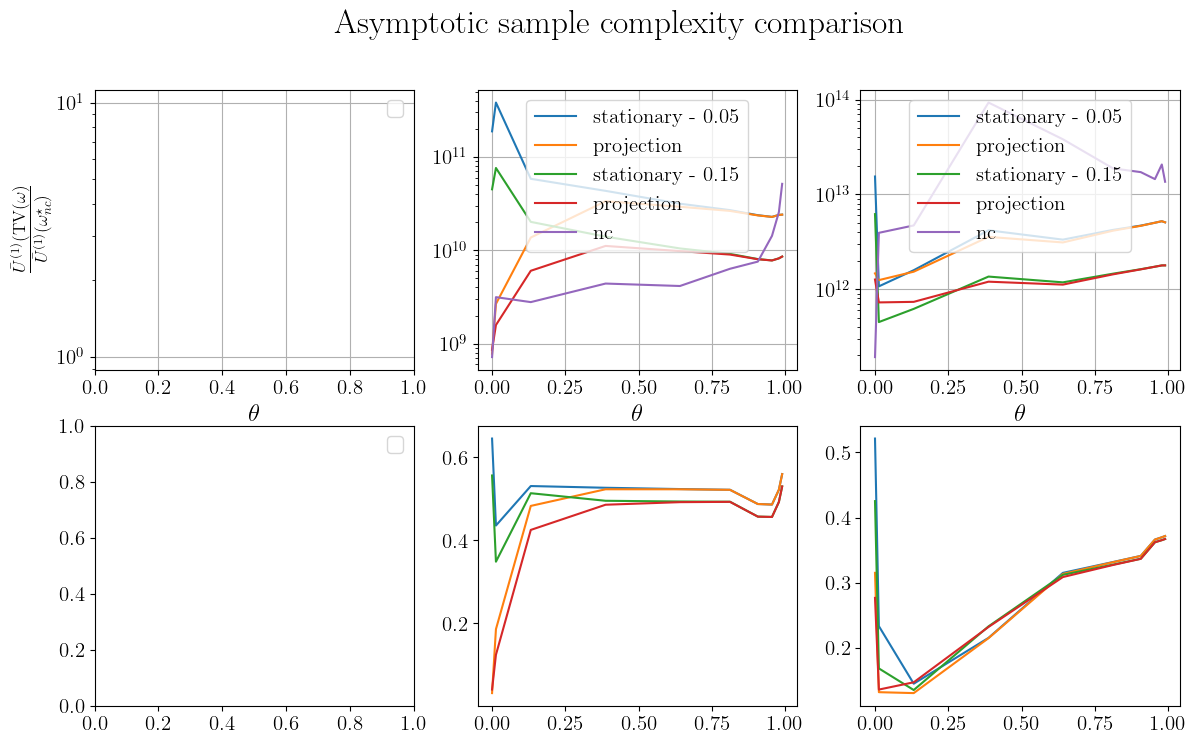

In [70]:
fig, ax = plt.subplots(2,3, figsize=(14,8))

markers = {
    5: '',
    10: ''
}

linestyles = {
    4: 'dotted',
    15: 'solid'
}

# mu0 = np.mean(random_res_U_C, 0)
# for id_eps, eps in enumerate(NEPS):
#     #mu = np.median(random_res_U_gen_stationary[:,:, id_eps], 0)
#     mu, ce = CE(random_res_U_gen_stationary[:,:, id_eps] / random_res_U_C[..., np.newaxis])
#     ax[0,0].plot(NTHETAS, mu, label=f'stationary - {eps}')#, linestyle=linestyles[na], marker=markers[ns])
#     ax[0,0].fill_between(NTHETAS, mu-ce, mu+ce, alpha=0.2)

#     #mu = np.median(random_res_U_gen_proj[:,:, id_eps], 0)
#     mu, ce = CE(random_res_U_gen_proj[:,:, id_eps] / random_res_U_C[..., np.newaxis])
#     ax[0,0].plot(NTHETAS, mu, label=f'projection- {eps}')#, linestyle=linestyles[na], marker=markers[ns])
#     ax[0,0].fill_between(NTHETAS, mu-ce, mu+ce, alpha=0.2)
    
# #mu = np.median(random_res_U_nc, 0)
# mu, ce = CE(random_res_U_nc / random_res_U_C[..., np.newaxis])
# ax[0,0].plot(NTHETAS, mu, label=f'nc')#, linestyle=linestyles[na], marker=markers[ns])
# ax[0,0].fill_between(NTHETAS, mu-ce, mu+ce, alpha=0.2)

#ax[0,0].plot(NTHETAS, 1*np.ones_like(NTHETAS), 'k--')
#ax[0].text(3e-2, 1.07, r'Optimal sampling $\omega_{nc,1}^\star$', fontsize=14)

ax[0,0].set_yscale('log')
#ax[0,0].set_xscale('log')
ax[0,0].grid()
ax[0,0].legend()
ax[0,0].set_xlabel(r'$\theta$')
ax[0,0].set_ylabel(r'$\frac{\bar U^{(1)}({\rm TV}(\omega)}{\bar U^{(1)}(\omega_{nc}^\star)}$')
#ax[0].yaxis.set_major_formatter(mticker.ScalarFormatter())



mu0 = riverswim_res_U_C

for id_eps, eps in enumerate(NEPS):
    #mu = riverswim_res_U_gen_stationary[:,id_eps] / mu0
    mu = riverswim_res_U_gen_stationary[..., id_eps]# / riverswim_res_U_C[..., np.newaxis]
    ax[0,1].plot(NTHETAS, mu, label=f'stationary - {eps}')#, linestyle=linestyles[na], marker=markers[ns])
    
    #mu = riverswim_res_U_gen_proj[:,id_eps]/ mu0
    mu = riverswim_res_U_gen_proj[..., id_eps] #/ riverswim_res_U_C[..., np.newaxis]
    ax[0,1].plot(NTHETAS, mu , label=r'projection')#, linestyle=linestyles[na], marker=markers[ns])

# ax[1].plot(NTHETAS, 1*np.ones_like(NTHETAS), 'k--')
# ax[1].text(3e-2, 1.07, r'Optimal sampling $\omega_{nc,1}^\star$', fontsize=14)

#mu = riverswim_res_U_nc/mu0

mu = riverswim_res_U_nc #/ riverswim_res_U_C
ax[0,1].plot(NTHETAS, mu, label=f'nc')#, linestyle=linestyles[na], marker=markers[ns])
ax[0,1].legend()
ax[0,1].set_yscale('log')
#ax[0,1].set_xscale('log')
ax[0,1].grid()
ax[0,1].set_xlabel(r'$\theta$')



################

mu0 = forked_riverswim_res_U_C

for id_eps, eps in enumerate(NEPS):
    mu = forked_riverswim_res_U_gen_stationary[:,id_eps] #/ mu0
    ax[0,2].plot(NTHETAS, mu, label=f'stationary - {eps}')#, linestyle=linestyles[na], marker=markers[ns])

    mu = forked_riverswim_res_U_gen_proj[:,id_eps]#/ mu0
    ax[0,2].plot(NTHETAS, mu , label=r'projection')#, linestyle=linestyles[na], marker=markers[ns])

# ax[1].plot(NTHETAS, 1*np.ones_like(NTHETAS), 'k--')
# ax[1].text(3e-2, 1.07, r'Optimal sampling $\omega_{nc,1}^\star$', fontsize=14)

mu = forked_riverswim_res_U_nc#/mu0
ax[0,2].plot(NTHETAS, mu, label=f'nc')#, linestyle=linestyles[na], marker=markers[ns])
ax[0,2].legend()
ax[0,2].set_yscale('log')
#ax[0,2].set_xscale('log')
ax[0,2].grid()
ax[0,2].set_xlabel(r'$\theta$')



######################


# for id_eps, eps in enumerate(NEPS):
#     mu = np.mean(random_res_TV_gen_stationary[:,:, id_eps], 0)
#     ax[1,0].plot(NTHETAS, mu, label=f'stationary - {eps}')#, linestyle=linestyles[na], marker=markers[ns])

#     mu = np.mean(random_res_TV_gen_proj[:,:, id_eps],0)
#     ax[1,0].plot(NTHETAS, mu, label=r'projection')#, linestyle=linestyles[na], marker=markers[ns])
#     #ax[1].yaxis.set_major_formatter(mticker.ScalarFormatter())


for id_eps, eps in enumerate(NEPS):
    mu = riverswim_res_TV_gen_stationary[:, id_eps]
    ax[1,1].plot(NTHETAS, mu, label=f'stationary - {eps}')#, linestyle=linestyles[na], marker=markers[ns])

    mu = riverswim_res_TV_gen_proj[:, id_eps]
    ax[1,1].plot(NTHETAS, mu , label=r'projection')#, linestyle=linestyles[na], marker=markers[ns])
    
    
##############

for id_eps, eps in enumerate(NEPS):
    mu = forked_riverswim_res_TV_gen_stationary[:, id_eps]
    ax[1,2].plot(NTHETAS, mu, label=f'stationary - {eps}')#, linestyle=linestyles[na], marker=markers[ns])

    mu = forked_riverswim_res_TV_gen_proj[:, id_eps]
    ax[1,2].plot(NTHETAS, mu , label=r'projection')#, linestyle=linestyles[na], marker=markers[ns])
#ax[1,0].set_xscale('log')
#ax[1,1].set_xscale('log')
#ax[1,2].set_xscale('log')
# ax[1].grid()
# ax[1].set_yscale('log')
# ax[1].set_xlabel(r'$\theta$')
# ax[1].set_ylabel(r'${\rm TV}(\omega, \omega_{nc}^\star)$')

# h1, l1 = ax[0].get_legend_handles_labels()

ax[1,0].legend(ncols=1)
plt.suptitle(f'Asymptotic sample complexity comparison')
plt.plot()

In [21]:
N_SIMS = 300
NS = 5
NEPS = 10**np.geomspace(-2, np.log10(0.99), 100)
NTHETAS = [0]
NA = 4
discount_factor = 0.99
np.random.seed(2)

In [75]:
random_res_U_gen_stationary = np.zeros((N_SIMS, len(NEPS)))
random_res_U_gen_proj = np.zeros((N_SIMS,len(NEPS)))
random_res_U_nc = np.zeros(N_SIMS)
random_res_TV_gen_stationary = np.zeros((N_SIMS, len(NEPS)))
random_res_TV_gen_proj = np.zeros((N_SIMS, len(NEPS)))
random_res_TV_nc = np.zeros( N_SIMS)
random_res_U_C = np.zeros(N_SIMS)


for sim in tqdm(range(N_SIMS)):
    while True:
        try:
            P0 = np.ones((NS, NA, NS)) / NS
            P = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(NS, NA))
            R = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(NS, NA))
            mdp = NewMDPDescription(P, R, discount_factor, 1)
            omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
            random_res_U_C[sim] = mdp.evaluate_allocation(omega_nav_constr)      
            
            mdp_theta = NewMDPDescription(P, R, discount_factor, 1)
            
            omega_gen_theta = mdp_theta.compute_allocation()[0]
            omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
            random_res_U_nc[sim] = mdp.evaluate_allocation(omega_nav_constr_theta)
            random_res_TV_nc[sim] = TV(omega_nav_constr_theta, omega_nav_constr)
            
            # Forced projected generative
            for id_eps, eps in enumerate(NEPS):
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((NS, NA)) / (NS * NA)
                omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, P)
                random_res_TV_gen_stationary[sim, id_eps] = TV(omega_gen_stationary, omega_nav_constr)
                random_res_U_gen_stationary[sim, id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

                # Unforced projected generative
                omega_gen_proj_eps = (1-eps)*omega_gen_theta + eps * np.ones((NS, NA)) / (NS * NA)
                omega_gen_proj_eps = project_omega(omega_gen_proj_eps, P, force_policy=False)
                random_res_TV_gen_proj[sim, id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
                random_res_U_gen_proj[sim, id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
            break
        except Exception as e:
            print(e)
            continue



with open('./data/data_generative_comparison_nc_randommdp_2.pkl', 'wb') as f:
    pickle.dump({'random_res_U_gen_stationary': random_res_U_gen_stationary, 'random_res_TV_gen_stationary': random_res_TV_gen_stationary,
                 'random_res_U_gen_proj': random_res_U_gen_proj, 'random_res_TV_gen_proj': random_res_TV_gen_proj,
                 'random_res_U_nc': random_res_U_nc, 'random_res_TV_nc': random_res_TV_nc,
                 'random_res_U_C': random_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

 84%|████████▎ | 251/300 [39:55<07:42,  9.44s/it]/home/alessio/anaconda3/envs/maze-exploration/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 300/300 [47:46<00:00,  9.55s/it]


In [3]:
riverswim_res_U_gen_stationary = np.zeros(len(NEPS))
riverswim_res_U_gen_proj = np.zeros(len(NEPS))
riverswim_res_U_nc =0
riverswim_res_TV_gen_stationary = np.zeros(len(NEPS))
riverswim_res_TV_gen_proj = np.zeros(len(NEPS))
riverswim_res_TV_nc = 0
riverswim_res_U_C = 0

NS_RIVER = 20
env = RiverSwim(num_states=NS_RIVER)

while True:
    try:
        P0 = np.ones((NS_RIVER, 2, NS_RIVER)) / NS_RIVER
        P = env.transitions
        R = env.rewards
        mdp = NewMDPDescription(P, R, discount_factor, 1)
        omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
        riverswim_res_U_C = mdp.evaluate_allocation(omega_nav_constr)      
        
        mdp_theta = NewMDPDescription(P, R, discount_factor, 1)
        
        omega_gen_theta = mdp_theta.compute_allocation()[0]
        omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
        riverswim_res_U_nc = mdp.evaluate_allocation(omega_nav_constr_theta)
        riverswim_res_TV_nc = TV(omega_nav_constr_theta, omega_nav_constr)
        
        # Forced projected generative
        for id_eps, eps in enumerate(NEPS):
            omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((20, 2)) / (20 * 2)
            omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, P)
            riverswim_res_TV_gen_stationary[id_eps] = TV(omega_gen_stationary, omega_nav_constr)
            riverswim_res_U_gen_stationary[id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

            # Unforced projected generative
            omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((20, 2)) / (20 * 2)
            omega_gen_proj_eps = project_omega(omega_gen_theta_eps, P, force_policy=False)
            riverswim_res_TV_gen_proj[id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
            riverswim_res_U_gen_proj[id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
        break
    except Exception as e:
        print(e)
        continue


with open('./data/data_generative_comparison_nc_riverswim_2.pkl', 'wb') as f:
    pickle.dump({'riverswim_res_U_gen_stationary': riverswim_res_U_gen_stationary, 'riverswim_res_TV_gen_stationary': riverswim_res_TV_gen_stationary,
                 'riverswim_res_U_gen_proj': riverswim_res_U_gen_proj, 'riverswim_res_TV_gen_proj': riverswim_res_TV_gen_proj,
                 'riverswim_res_U_nc': riverswim_res_U_nc, 'riverswim_res_TV_nc': riverswim_res_TV_nc,
                 'riverswim_res_U_C': riverswim_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
forked_riverswim_res_U_gen_stationary = np.zeros(len(NEPS))
forked_riverswim_res_U_gen_proj = np.zeros(len(NEPS))
forked_riverswim_res_U_nc =0
forked_riverswim_res_TV_gen_stationary = np.zeros(len(NEPS))
forked_riverswim_res_TV_gen_proj = np.zeros(len(NEPS))
forked_riverswim_res_TV_nc = 0
forked_riverswim_res_U_C = 0

env = ForkedRiverSwim(10)

ns, na = env.transitions.shape[0], env.transitions.shape[1]

while True:
    try:
        P0 = np.ones((ns, na, ns)) / ns
        P = env.transitions
        R = env.rewards
        mdp = NewMDPDescription(P, R, discount_factor, 1)
        omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
        forked_riverswim_res_U_C = mdp.evaluate_allocation(omega_nav_constr)      
        
        mdp_theta = NewMDPDescription(P, R, discount_factor, 1)
        
        omega_gen_theta = mdp_theta.compute_allocation()[0]
        omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
        forked_riverswim_res_U_nc = mdp.evaluate_allocation(omega_nav_constr_theta)
        forked_riverswim_res_TV_nc = TV(omega_nav_constr_theta, omega_nav_constr)
        
        # Forced projected generative
        for id_eps, eps in enumerate(NEPS):
            omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((ns, na)) / (ns * na)
            omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, P)
            forked_riverswim_res_TV_gen_stationary[id_eps] = TV(omega_gen_stationary, omega_nav_constr)
            forked_riverswim_res_U_gen_stationary[id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

            # Unforced projected generative
            omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((ns, na)) / (ns * na)
            omega_gen_proj_eps = project_omega(omega_gen_theta_eps, P, force_policy=False)
            forked_riverswim_res_TV_gen_proj[id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
            forked_riverswim_res_U_gen_proj[id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
        break
    except Exception as e:
        print(e)
        continue


with open('./data/data_generative_comparison_nc_forked_riverswim_2.pkl', 'wb') as f:
    pickle.dump({'forked_riverswim_res_U_gen_stationary': forked_riverswim_res_U_gen_stationary, 'forked_riverswim_res_TV_gen_stationary': forked_riverswim_res_TV_gen_stationary,
                 'forked_riverswim_res_U_gen_proj': forked_riverswim_res_U_gen_proj, 'forked_riverswim_res_TV_gen_proj': forked_riverswim_res_TV_gen_proj,
                 'forked_riverswim_res_U_nc': forked_riverswim_res_U_nc, 'forked_riverswim_res_TV_nc': forked_riverswim_res_TV_nc,
                 'forked_riverswim_res_U_C': forked_riverswim_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
with open('./data/data_generative_comparison_nc_randommdp_2.pkl', 'rb') as f:
    data = pickle.load(f)
    

random_res_U_gen_stationary = data['random_res_U_gen_stationary']
random_res_U_gen_proj = data['random_res_U_gen_proj']
random_res_U_nc = data['random_res_U_nc']
random_res_TV_gen_stationary = data['random_res_TV_gen_stationary']
random_res_TV_gen_proj = data['random_res_TV_gen_proj']
random_res_TV_nc = data['random_res_TV_nc']
random_res_U_C = data['random_res_U_C']


with open('./data/data_generative_comparison_nc_riverswim_2.pkl', 'rb') as f:
    data = pickle.load(f)
    

riverswim_res_U_gen_stationary = data['riverswim_res_U_gen_stationary']
riverswim_res_U_gen_proj = data['riverswim_res_U_gen_proj']
riverswim_res_U_nc = data['riverswim_res_U_nc']
riverswim_res_TV_gen_stationary = data['riverswim_res_TV_gen_stationary']
riverswim_res_TV_gen_proj = data['riverswim_res_TV_gen_proj']
riverswim_res_TV_nc = data['riverswim_res_TV_nc']
riverswim_res_U_C = data['riverswim_res_U_C']


with open('./data/data_generative_comparison_nc_forked_riverswim_2.pkl', 'rb') as f:
    data = pickle.load(f)
    

forked_riverswim_res_U_gen_stationary = data['forked_riverswim_res_U_gen_stationary']
forked_riverswim_res_U_gen_proj = data['forked_riverswim_res_U_gen_proj']
forked_riverswim_res_U_nc = data['forked_riverswim_res_U_nc']
forked_riverswim_res_TV_gen_stationary = data['forked_riverswim_res_TV_gen_stationary']
forked_riverswim_res_TV_gen_proj = data['forked_riverswim_res_TV_gen_proj']
forked_riverswim_res_TV_nc = data['forked_riverswim_res_TV_nc']
forked_riverswim_res_U_C = data['forked_riverswim_res_U_C']

[]

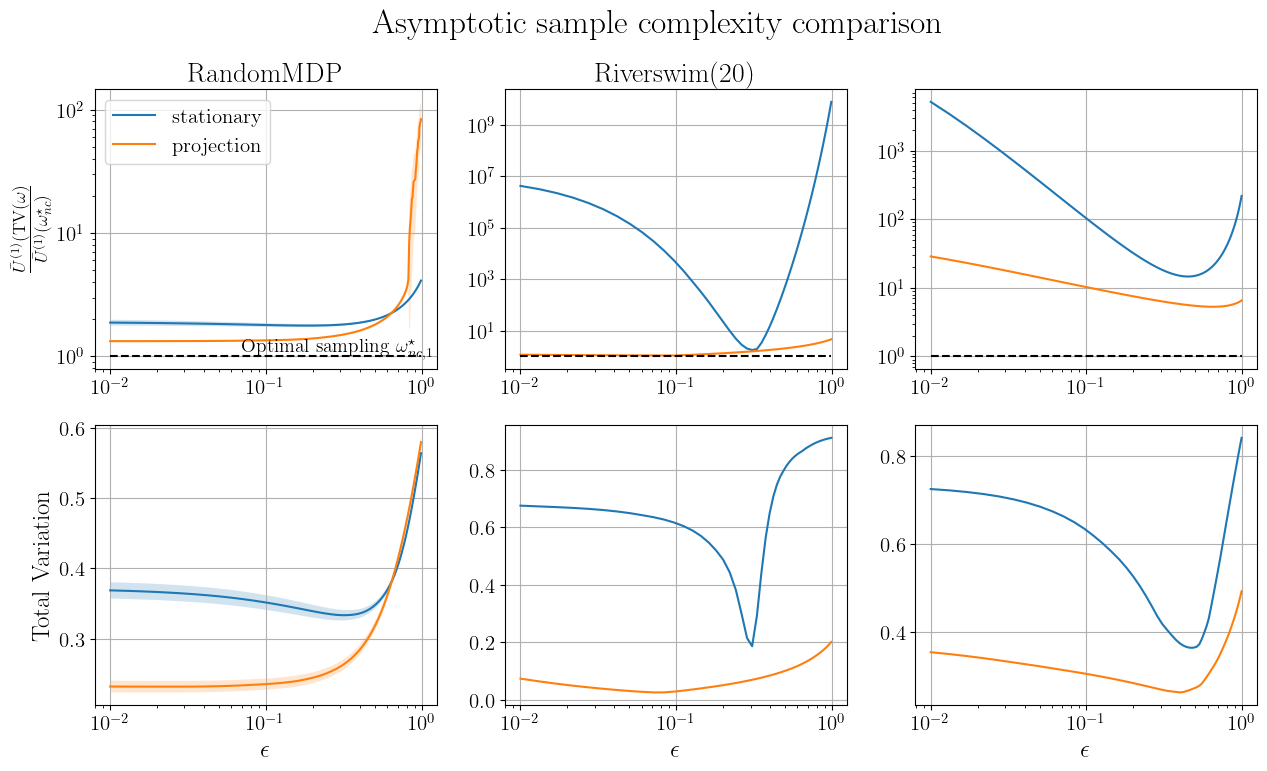

In [30]:
fig, ax = plt.subplots(2,3, figsize=(15,8))

markers = {
    5: '',
    10: ''
}

linestyles = {
    4: 'dotted',
    15: 'solid'
}

mu, ce = CE(((random_res_U_gen_stationary ) / random_res_U_C[...,np.newaxis]))
ax[0,0].plot(NEPS, mu, label=f'stationary ')
ax[0,0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)

mu, ce = CE(((random_res_U_gen_proj ) / random_res_U_C[...,np.newaxis]))
ax[0,0].plot(NEPS, mu, label=f'projection ')
ax[0,0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)

ax[0,0].plot(NEPS, 1*np.ones_like(NEPS), 'k--')
ax[0,0].text(7e-2, 1.1, r'Optimal sampling $\omega_{nc,1}^\star$', fontsize=14)

ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].grid()
ax[1,0].set_xlabel(r'$\epsilon$')
ax[0,0].set_ylabel(r'$\frac{\bar U^{(1)}({\rm TV}(\omega)}{\bar U^{(1)}(\omega_{nc}^\star)}$')

mu = (riverswim_res_U_gen_stationary)/ riverswim_res_U_C
ax[0,1].plot(NEPS, mu, label=f'stationary - {eps}')

mu = (riverswim_res_U_gen_proj)/ riverswim_res_U_C
ax[0,1].plot(NEPS, mu , label=r'projection')#, linestyle=linestyles[na], marker=markers[ns])
ax[0,1].plot(NEPS, 1*np.ones_like(NEPS), 'k--')
ax[0,1].set_yscale('log')
ax[0,1].grid()
ax[1,1].set_xlabel(r'$\epsilon$')
ax[0,1].set_xscale('log')


mu = (forked_riverswim_res_U_gen_stationary)/ forked_riverswim_res_U_C
ax[0,2].plot(NEPS, mu, label=f'stationary - {eps}')

mu = (forked_riverswim_res_U_gen_proj)/ forked_riverswim_res_U_C
ax[0,2].plot(NEPS, mu , label=r'projection')#, linestyle=linestyles[na], marker=markers[ns])
ax[0,2].plot(NEPS, 1*np.ones_like(NEPS), 'k--')
ax[0,2].set_yscale('log')
ax[0,2].grid()
ax[1,2].set_xlabel(r'$\epsilon$')
ax[0,2].set_xscale('log')

mu, ce =  CE(random_res_TV_gen_stationary)
ax[1,0].plot(NEPS, mu, label=f'stationary - {eps}')
ax[1,0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)

mu, ce =  CE(random_res_TV_gen_proj)
ax[1,0].plot(NEPS, mu, label=r'projection')
ax[1,0].fill_between(NEPS, mu-ce, mu+ce, alpha=0.2)
ax[1,0].set_xscale('log')
ax[1,0].grid()

mu = riverswim_res_TV_gen_stationary
ax[1,1].plot(NEPS, mu, label=f'stationary - {eps}')#, linestyle=linestyles[na], marker=markers[ns])

mu = riverswim_res_TV_gen_proj
ax[1,1].plot(NEPS, mu , label=r'projection')#, linestyle=linestyles[na], marker=markers[ns])
ax[1,1].set_xscale('log')
ax[1,1].grid()

mu = forked_riverswim_res_TV_gen_stationary
ax[1,2].plot(NEPS, mu, label=f'stationary - {eps}')#, linestyle=linestyles[na], marker=markers[ns])

mu = forked_riverswim_res_TV_gen_proj
ax[1,2].plot(NEPS, mu , label=r'projection')#, linestyle=linestyles[na], marker=markers[ns])
ax[1,2].set_xscale('log')
ax[1,2].grid()
# ax[1].set_xlabel(r'$\theta$')
# ax[1].set_ylabel(r'${\rm TV}(\omega, \omega_{nc}^\star)$')

# h1, l1 = ax[0].get_legend_handles_labels()

ax[0,0].legend(ncols=1)

#ax[0,0].set_ylabel('Sample Complexity')
ax[0,0].set_title('RandomMDP')

#ax2 = ax[1,1].twinx() 
#ax2.set_yticks([])
ax[1,0].set_ylabel(r'Total Variation')
ax[0,1].set_title('Riverswim(20)')
plt.suptitle(f'Asymptotic sample complexity comparison')
plt.plot()

In [17]:
forked_riverswim_res_U_C-forked_riverswim_res_U_gen_stationary

array([-1.89661110e+22, -1.25847875e+22, -8.35868950e+21, -5.59069733e+21,
       -3.78209399e+21, -2.59571017e+21, -1.81093797e+21, -1.28588989e+21,
       -9.29917128e+20, -6.85083758e+20, -5.14170168e+20, -3.93065611e+20,
       -3.05988296e+20, -2.42487265e+20, -1.95555640e+20, -1.60435645e+20,
       -1.33855722e+20, -1.13538035e+20, -9.78774123e+19, -8.57296524e+19,
       -7.62703251e+19, -6.88995227e+19, -6.31768753e+19, -5.87767189e+19,
       -5.54568298e+19, -5.30363854e+19, -5.13802665e+19, -5.03877585e+19,
       -4.99843350e+19, -5.01156169e+19, -5.07428811e+19, -5.18396794e+19,
       -5.33892578e+19, -5.53825549e+19, -5.78166217e+19, -6.06933471e+19,
       -6.40184077e+19, -6.78003793e+19, -7.20499686e+19, -7.67793312e+19,
       -8.20014565e+19, -8.77296009e+19, -9.39767625e+19, -1.00755190e+20,
       -1.08075920e+20, -1.15948355e+20, -1.24379860e+20, -1.33375411e+20,
       -1.42937269e+20, -1.53064708e+20, -1.63753785e+20, -1.74997161e+20,
       -1.86783984e+20, -

In [11]:
riverswim_res_U_C

712942429.0211152